In [1]:
using Downloads, LinearAlgebra, FFTW, Random
using CSV, DataFrames, DataFramesMeta
using Statistics, StatsPlots
using ForwardDiff
using Printf
using Plots

In [2]:
struct SourceLocalization
    c::Matrix{Float64} # 2x`m` matrix with the beacon positions
    d::Vector{Float64} # vector of distances (noisy)
    x::Vector{Float64} # true position (you're not meant to know this!)
end

In [3]:

function r(sl,x)
    rx = zeros(size(sl.c,2))
    for i in 1:size(sl.c,2)
        rx[i] = dot(x - sl.c[:,i], x - sl.c[:,i])  - sl.d[i]^2
    end
    return rx
end

function J(sl,x)
    Jx = zeros(size(sl.c)[2], length(x))
    for i in 1:size(sl.c)[2]
        Jx[i, :] .= 2 * x - 2 * sl.c[:, i]
    end
    return Jx
end

function Hr(sl,x,rx)
    Hrx = zeros(length(x), length(x))
    Hrx[1,1] = 2 * dot(ones(size(sl.c)[2]),rx)
    Hrx[2,2] = 2 * dot(ones(size(sl.c)[2]),rx)
    return Hrx
end

Hr (generic function with 1 method)

In [4]:
function gauss_newton(sl,x0, maxits=100, ϵ=1e-6, μ=1e-4)
    x = x0
    k = 0
    itn_err = Float64[]
    x1tr = Float64[]
    x2tr = Float64[]
    rx = r(sl, x)
    Jx = J(sl, x)    
    push!(x1tr,x0[1])
    push!(x2tr,x0[2])
#    push!(itn_err, norm(Jx' * rx)) # Initialize with initial error
    push!(itn_err,0.5*dot(rx, rx))   # Initialize with initial error
    for i in 1:maxits
        rx = r(sl,x)
        Jx = J(sl,x)
        Hrx = Hr(sl,x,rx)
        dx = -(Jx'*Jx + Hrx)\(Jx'*rx)
        α = 1.0
        β = 0.5
        directional_derivative = (Jx'*rx)'*dx
        f_old = 0.5*dot(rx,rx)
        f_new = 0.5*dot(r(sl,x + α*dx),r(sl,x + α*dx))
        while f_new >= f_old + α *μ* directional_derivative
            α *= β
            f_new = 0.5*dot(r(sl,x + α*dx),r(sl,x + α*dx))
            if norm(α) < ϵ
                break
            end    
        end
        if norm(dx) < ϵ
            break
        end
        x += α*dx 
        k += 1
        push!(itn_err,0.5*dot(rx, rx))   # Initialize with initial error
#        push!(itn_err,norm(dx)) 
        push!(x1tr,x[1])
        push!(x2tr,x[2])
    end
    xtr= zeros(2,k+1)
    xtr[1,:] = vec(x1tr)
    xtr[2,:] = vec(x2tr ) 
    return x, k, itn_err, xtr
end

gauss_newton (generic function with 4 methods)

In [5]:
function gradient_descent(sl, x0, maxits=100, ϵ=1e-6, μ=1e-4)
    x = x0
    k = 0
    itn_err = Float64[]
    x1tr = Float64[]
    x2tr = Float64[]
    rx = r(sl, x)
    Jx = J(sl, x)    
    push!(x1tr,x0[1])
    push!(x2tr,x0[2])
#    push!(itn_err,norm(Jx' * rx))   # Initialize with initial error
    push!(itn_err,0.5*dot(rx, rx))   # Initialize with initial error
    for i in 1:maxits
        rx = r(sl, x)
        Jx = J(sl, x)
        α = 1
        β = 0.5
        dx = -Jx' * rx
        directional_derivative = (Jx' * rx)' * dx
        f_old = 0.5 * dot(rx, rx)
        f_new = 0.5 * dot(r(sl, x + α * dx), r(sl, x + α * dx))
        while f_new >= f_old + α * μ * directional_derivative
            α *= β
            f_new = 0.5 * dot(r(sl, x + α * dx), r(sl, x + α * dx))
            if norm(α) < ϵ
                break
            end    
        end
        if norm(dx) < ϵ
            break
        end
        x += α * dx 
        k += 1
#        push!(itn_err, norm(dx)) 
        push!(itn_err,0.5*dot(rx, rx))   # Initialize with initial error
        push!(x1tr,x[1])
        push!(x2tr,x[2])
    end
    xtr= zeros(2,k+1)
    xtr[1,:] = vec(x1tr)
    xtr[2,:] = vec(x2tr )   
    return x, k, itn_err, xtr
end


gradient_descent (generic function with 4 methods)

In [6]:
function generate_data(m, η=0.1)
    c = 2.0.*randn(2, m)  # beacon positions
    x = randn(2)     # true (unkown) position
    d = [norm(x - ci) + η*randn() for ci in eachcol(c)]
    return SourceLocalization(c , d, x)
end

generate_data (generic function with 2 methods)

In [7]:
function localize_source(sl,optimization,x0)
    xest, k, itn_err, xtr = optimization(sl, x0) 
    return xest, k, itn_err, xtr
end

localize_source (generic function with 1 method)

In [8]:
function plotmap(sl)
#    scatter!(xguess[1,:], xguess[2,:], label="guess", c="orange", ms=5)
    scatter!(sl.c[1,:], sl.c[2,:], color=:green,label="beacons", shape=:square, ms=3)
    for i in 1:size(sl.c, 2)
        θ = LinRange(0, 2π, 100)  # Create points along the circumference
        cx = sl.c[1, i] .+ sl.d[i] * cos.(θ)  # x-coordinates of the circle points
        cy = sl.c[2, i] .+ sl.d[i] * sin.(θ)  # y-coordinates of the circle points
        plot!(cx, cy, label="Dist from b_$i",color=:black)
    end
    scatter!(sl.x[1,:], sl.x[2,:], color=:red,label="true position", shape=:cross, ms=10)
end


plotmap (generic function with 1 method)

In [9]:
function get_rgrid(sl, xar, nx1=200,nx2=200, mirgin=0.1)
    x1range = [minimum(xar[1,:]), maximum(xar[1,:])]
    x1range += mirgin.*[-1,1]
    x2range = [minimum(xar[2,:]), maximum(xar[2,:])]
    x2range += mirgin.*[-1,1]
    x1grid, x2grid, rgrid = zeros(nx1+1), zeros(nx2+1), zeros(nx1+1,nx2+1)

    for ix1 in 1:nx1+1
        x1grid[ix1] = (nx1 - ix1-1)/nx1*x1range[1] + (ix1-1)/nx1*x1range[2]
    end

    for ix2 in 1:nx2+1
        x2grid[ix2] = (nx2 - ix2 -1)/nx2*x2range[1] + (ix2-1)/nx2*x2range[2]
    end

    for ix2 in 1:nx2+1
        for ix1 in 1:nx1+1
            x = [x1grid[ix1],x2grid[ix2]]
            rx = r(sl, x)
            rgrid[ix2,ix1] = 0.5*dot(rx, rx)
#            Jx = J(sl, x)
#            rgrid[ix2,ix1] = norm(Jx' * rx)
        end
    end
    return x1grid, x2grid, rgrid 
end


get_rgrid (generic function with 4 methods)

In [85]:
m = 4
η= 0.1
sl = generate_data(m,η) # Assuming generate_data returns a tuple with appropriate types
x0 = randn(2)
xest1, k1, itn_err1, xtr1 = localize_source(sl, gradient_descent,x0)
xest2, k2, itn_err2, xtr2 = localize_source(sl, gauss_newton,x0)

([-0.14370692489235765, 0.7383784674640617], 5, [91.78509489460403, 91.78509489460403, 12.535024389367877, 0.7037203758877878, 0.5285268079732807, 0.5282999942928515], [1.5879769085772797 -0.5639139868704481 … -0.14371278355717476 -0.14370692489235765; 0.2922824509612468 0.675706648619945 … 0.7383863401651665 0.7383784674640617])

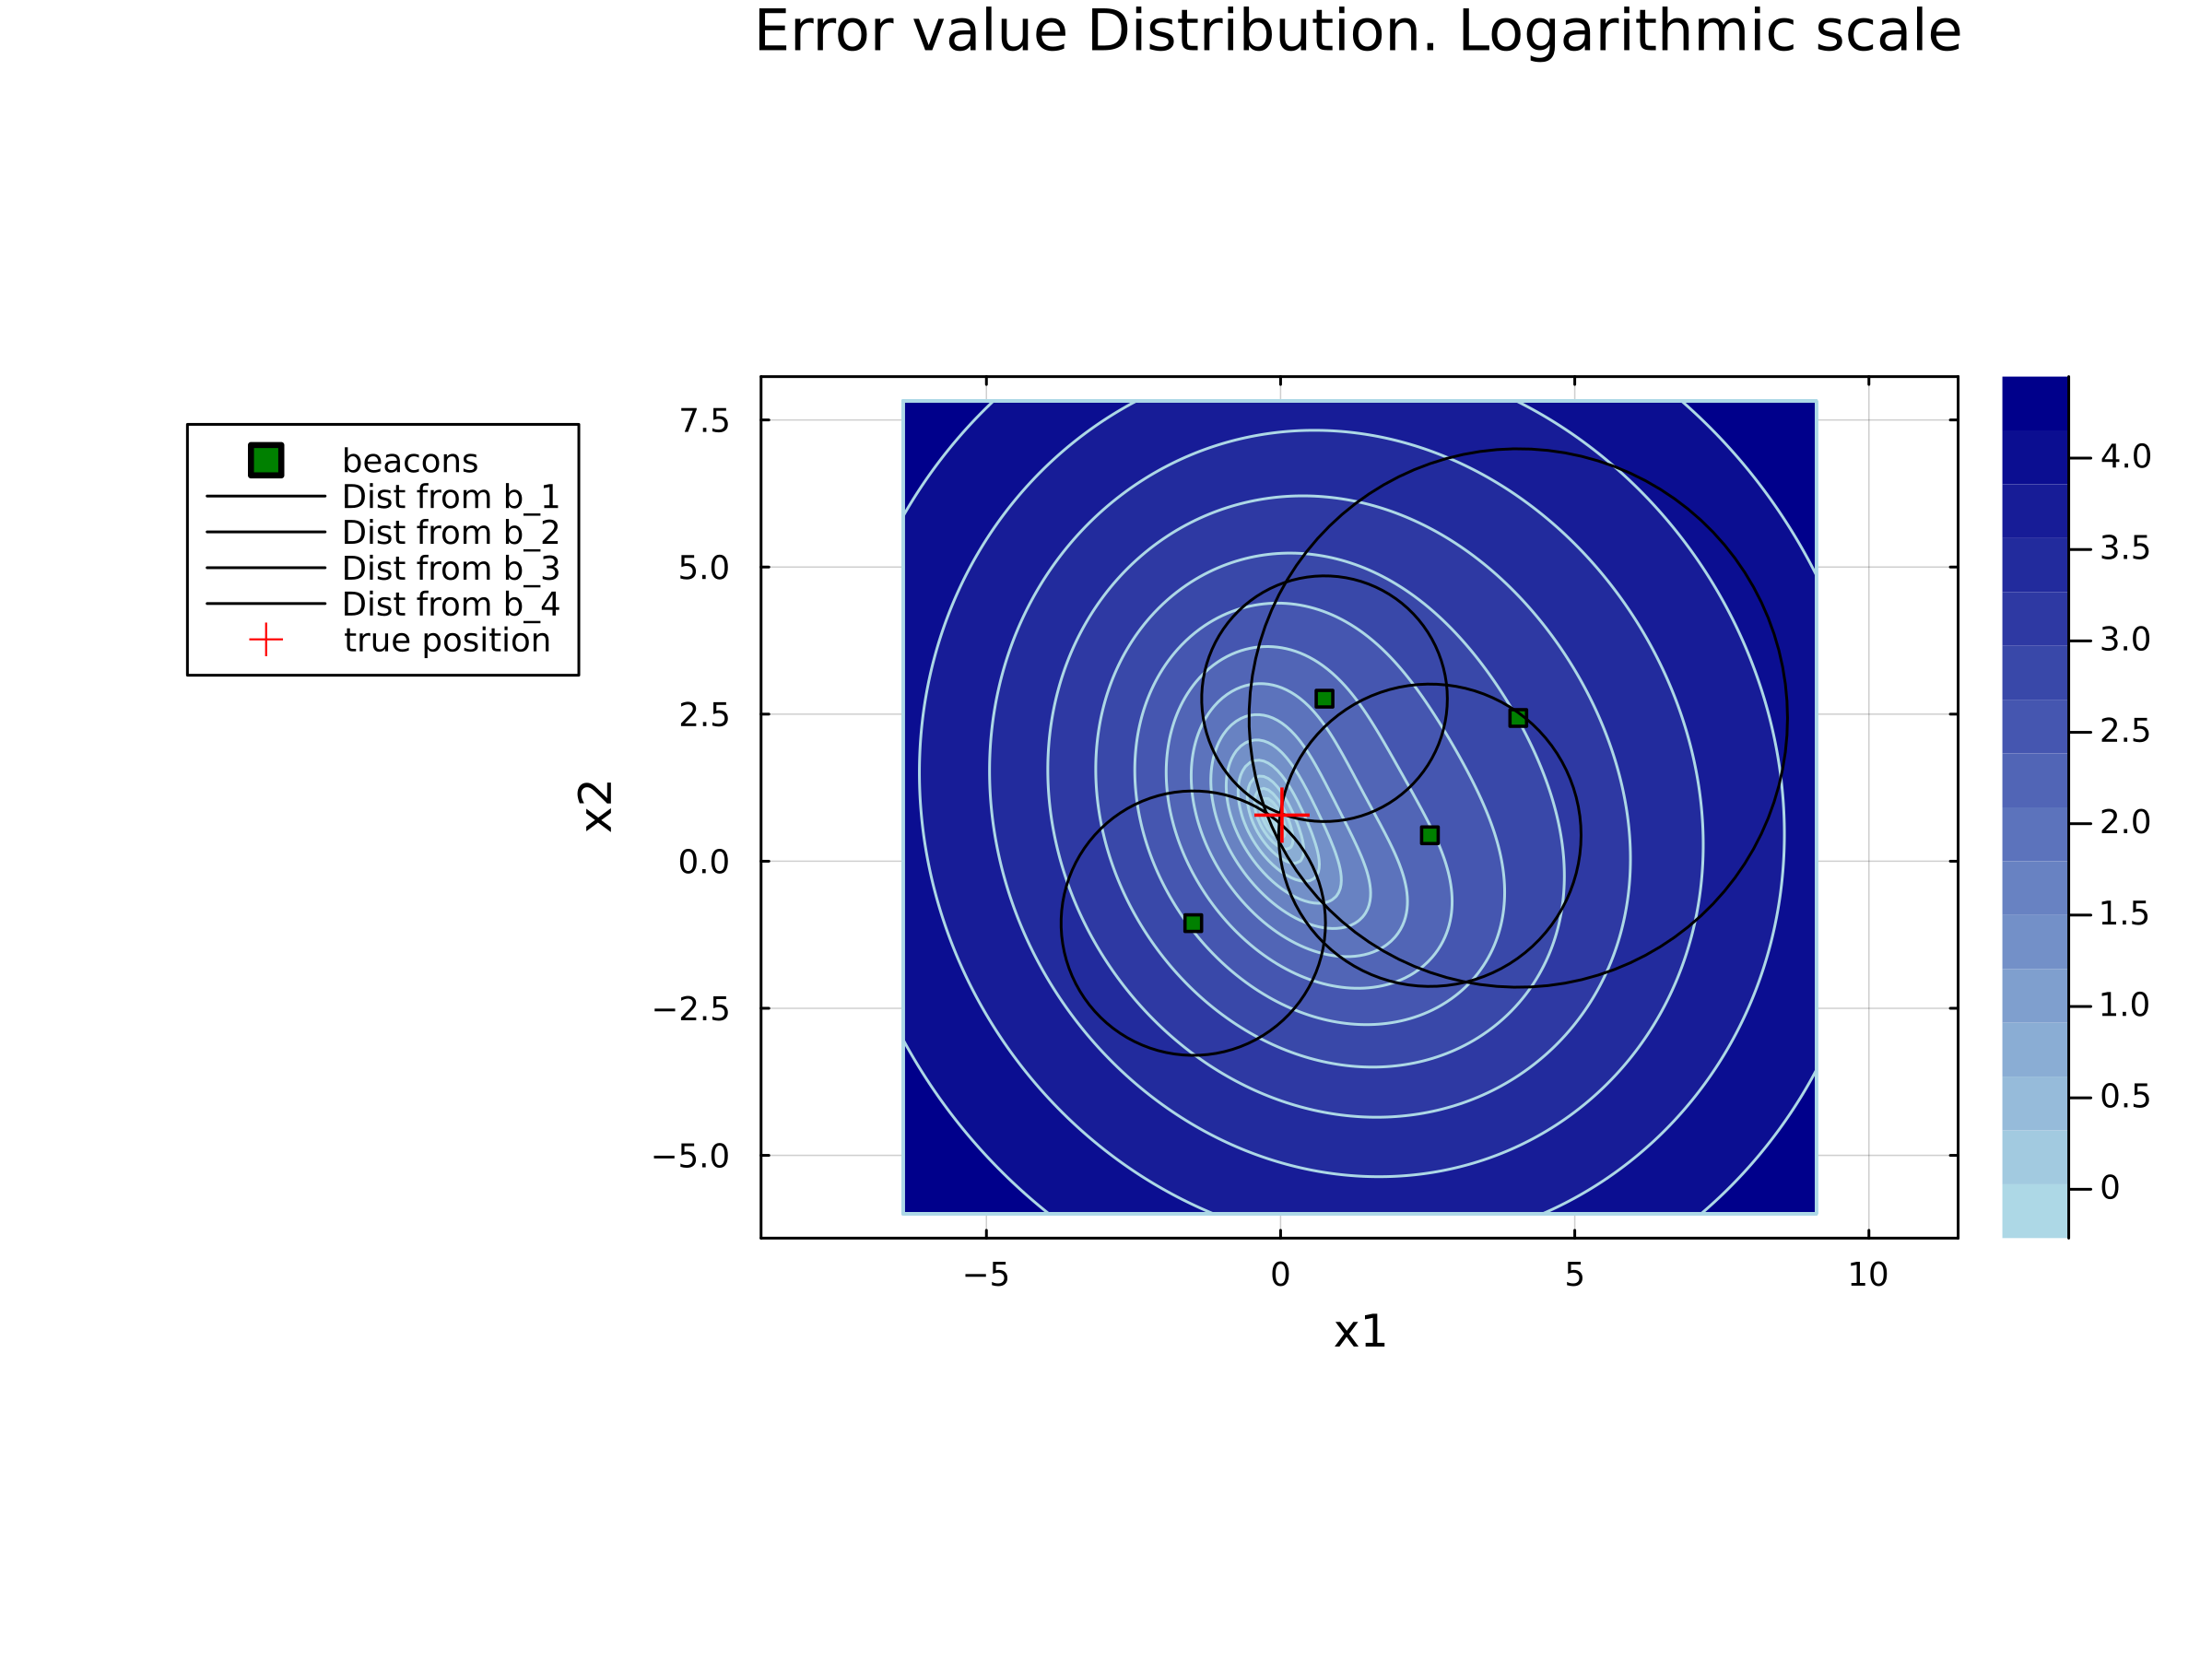

In [95]:
xar = hcat(sl.c, sl.x)
nx1, nx2, mirgin = 200, 200, 5
x1grid, x2grid, rgrid = get_rgrid(sl, xar, nx1, nx2, mirgin)
num_points = 20
tv = collect(range(log10(minimum(rgrid)), stop=log10(maximum(rgrid)), length=num_points))
tl = ["$(@sprintf("%.2e", 10^i))" for i in tv]
contourf(x1grid, x2grid, log10.(rgrid), colorbar_ticks=(tv, tl), color=:blues, lw=1 )  # Added cbar_label argument
plotmap(sl)
plot!(leg=:outertopleft, frame=:box, title="Error value Distribution. Logarithmic scale", 
    xlabel="x1", ylabel="x2", aspect_ratio=:equal, size=(800, 600), dpi=300)
#savefig("Hw4_extra_ErrorDist.png")

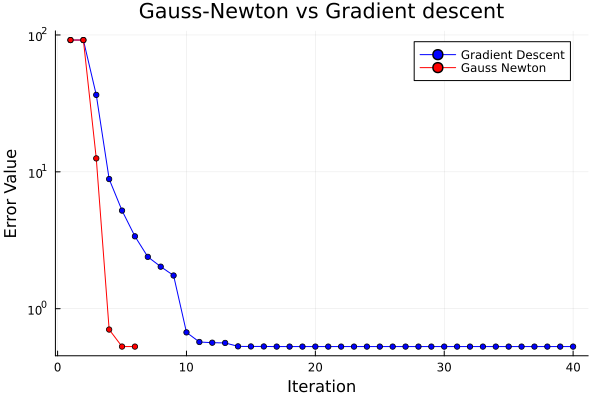

In [97]:
# Plot the error data
plot(itn_err1, label="Gradient Descent", yscale=:log10, markersize=3, color=:blue, marker=:circle)
plot!(itn_err2, label="Gauss Newton", yscale=:log10, markersize=3, color=:red, marker=:circle)
xlabel!("Iteration")
ylabel!("Error Value")
title!("Gauss-Newton vs Gradient descent")
#savefig("Hw4_extra_ErrorItr.png")

In [98]:
min_value = minimum(itn_err1)
max_value = maximum(itn_err1)
num_points = 20
tv2 = collect(range(log10(min_value), stop=log10(max_value), length=num_points))
tl2 = ["$(@sprintf("%.2e", 10^i))" for i in tv]

20-element Vector{String}:
 "5.40e-01"
 "9.57e-01"
 "1.69e+00"
 "3.00e+00"
 "5.31e+00"
 "9.40e+00"
 "1.66e+01"
 "2.95e+01"
 "5.21e+01"
 "9.23e+01"
 "1.63e+02"
 "2.89e+02"
 "5.12e+02"
 "9.07e+02"
 "1.61e+03"
 "2.84e+03"
 "5.03e+03"
 "8.91e+03"
 "1.58e+04"
 "2.79e+04"

In [99]:
xar = hcat(sl.x, hcat(xtr1))
nx1,nx2, mirgin = 200,200,0.5
x1grid, x2grid, rgrid = get_rgrid(sl,xar,nx1,nx2,mirgin)

([-0.685933773778499, -0.6720295772468322, -0.6581253807151655, -0.6442211841834988, -0.6303169876518322, -0.6164127911201654, -0.6025085945884987, -0.588604398056832, -0.5747002015251653, -0.5607960049934987  …  1.9697677637698396, 1.9836719603015063, 1.9975761568331731, 2.0114803533648398, 2.0253845498965064, 2.0392887464281735, 2.05319294295984, 2.0670971394915068, 2.0810013360231734, 2.09490553255484], [-0.9877688533290621, -0.9763633651969196, -0.964957877064777, -0.9535523889326344, -0.9421469008004917, -0.9307414126683492, -0.9193359245362066, -0.907930436404064, -0.8965249482719214, -0.8851194601397789  …  1.1906793799101703, 1.2020848680423128, 1.2134903561744554, 1.224895844306598, 1.2363013324387406, 1.2477068205708832, 1.2591123087030258, 1.2705177968351684, 1.2819232849673108, 1.2933287730994536], [181.70077576982155 178.90803752359767 … 119.32392628502167 120.86797407449735; 179.48608605036367 176.70990200577864 … 118.92419992387707 120.46985926077122; … ; 14.364765586739

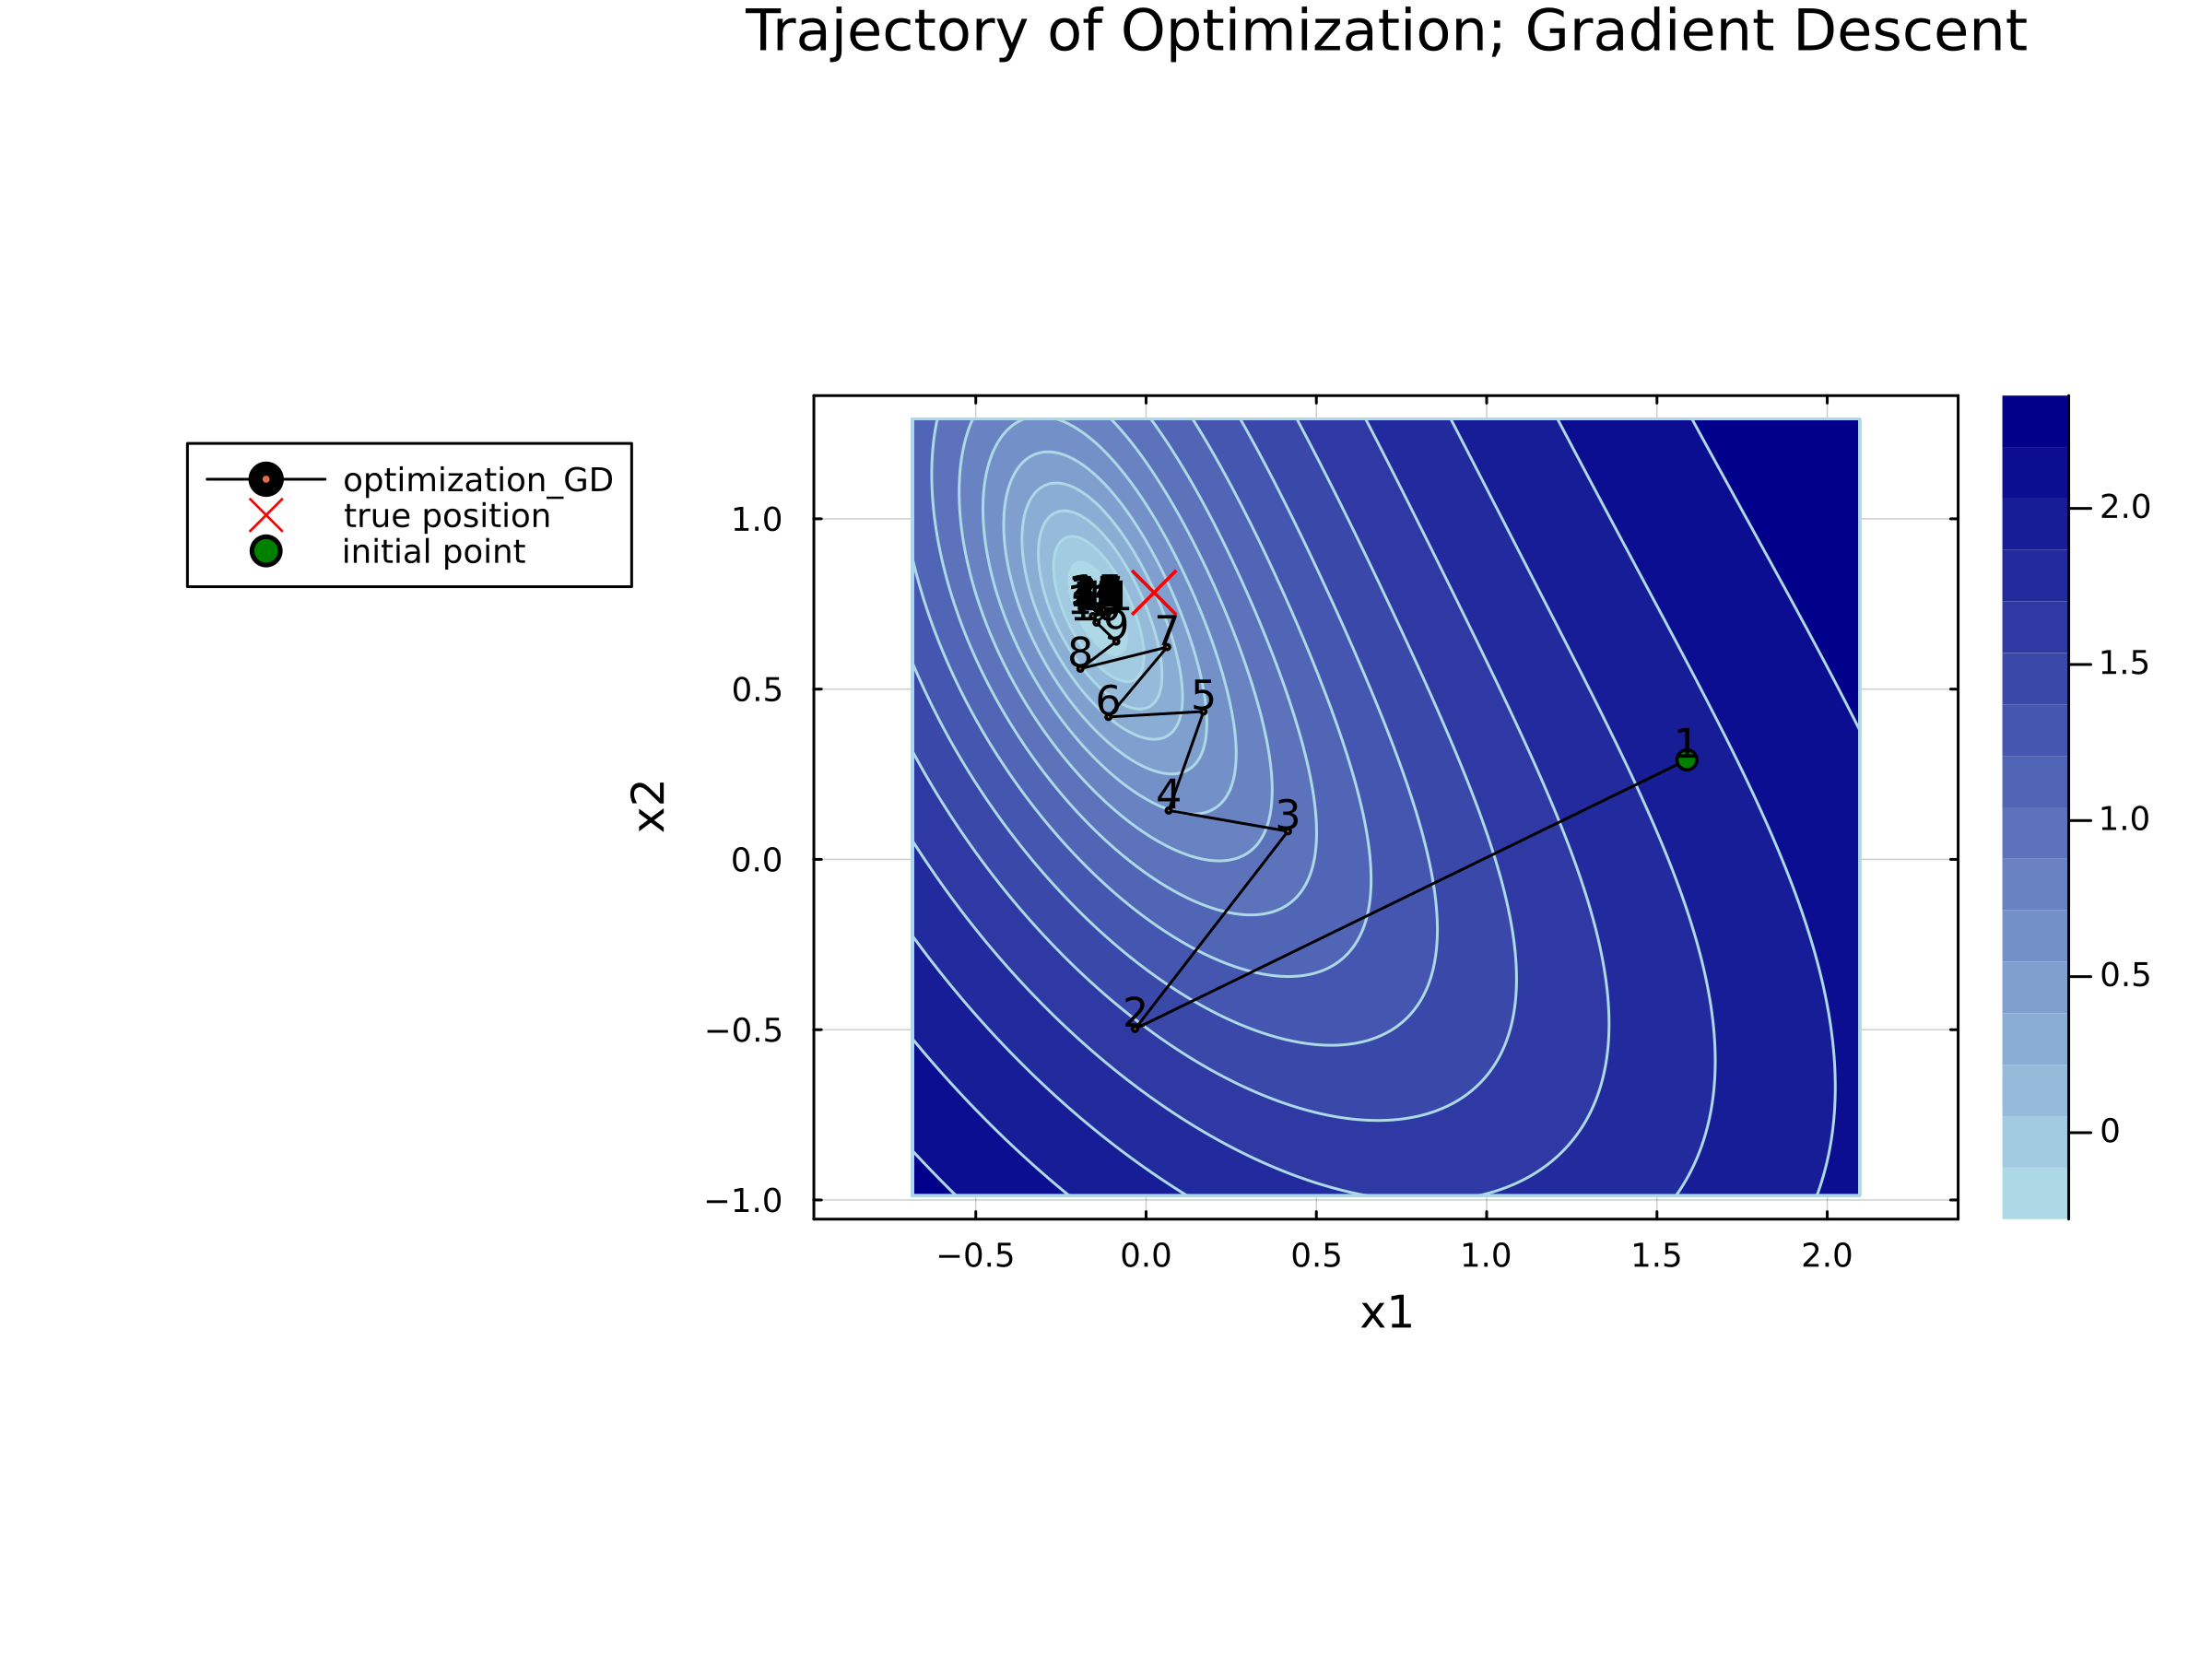

In [101]:
contourf(x1grid, x2grid, log10.(rgrid), colorbar_ticks=(tv2,tl2), color=:blues, label="Contour Levels")
plot!(xtr1[1,:], xtr1[2,:], linecolor=:black, marker=:circle, 
    markerstrokecolor=:black, markersize=1, label="optimization_GD")
indices = 1:size(xtr1, 2)  # Generate indices for each point
for i in 1:length(indices)
    annotate!(xtr1[1, i], xtr1[2, i] + 0.05, text(indices[i], :black, :center, 10))
end
scatter!(sl.x[1,:], sl.x[2,:], label="true position", color=:red,shape=:xcross, ms=8)
scatter!([x0[1]], [x0[2]], label="initial point", color=:green, shape=:circle, ms=4)
plot!(leg=:outertopleft, frame=:box, title="Trajectory of Optimization; Gradient Descent", 
    xlabel="x1", ylabel="x2", aspect_ratio=:equal, size=(800, 600), dpi=300)
#savefig("Hw4_extra_GD_tr.png")

In [102]:
xar = hcat(sl.x, hcat(xtr2))
nx1,nx2, mirgin = 200,200,0.5
x1grid, x2grid, rgrid = get_rgrid(sl,xar,nx1,nx2,mirgin)

([-1.0532748470017437, -1.037515392524505, -1.0217559380472665, -1.0059964835700277, -0.9902370290927892, -0.9744775746155505, -0.9587181201383117, -0.942958665661073, -0.9271992111838344, -0.9114397567065958  …  1.9567809581508362, 1.9725404126280748, 1.9882998671053134, 2.004059321582552, 2.0198187760597905, 2.0355782305370296, 2.051337685014268, 2.0670971394915068, 2.0828565939687453, 2.098616048445984], [-0.2056403735483657, -0.19818502925349935, -0.19072968495863302, -0.1832743406637667, -0.17581899636890036, -0.168363652074034, -0.16090830777916768, -0.15345296348430135, -0.14599761918943502, -0.13854227489456866  …  1.2183303867711042, 1.2257857310659703, 1.2332410753608367, 1.2406964196557029, 1.2481517639505693, 1.2556071082454359, 1.263062452540302, 1.2705177968351684, 1.2779731411300346, 1.285428485424901], [132.33844575409222 129.19070781724176 … 123.92894526009098 125.85511262369656; 131.4129395879152 128.2752576754791 … 124.21768538219224 126.14596025940232; … ; 45.297605

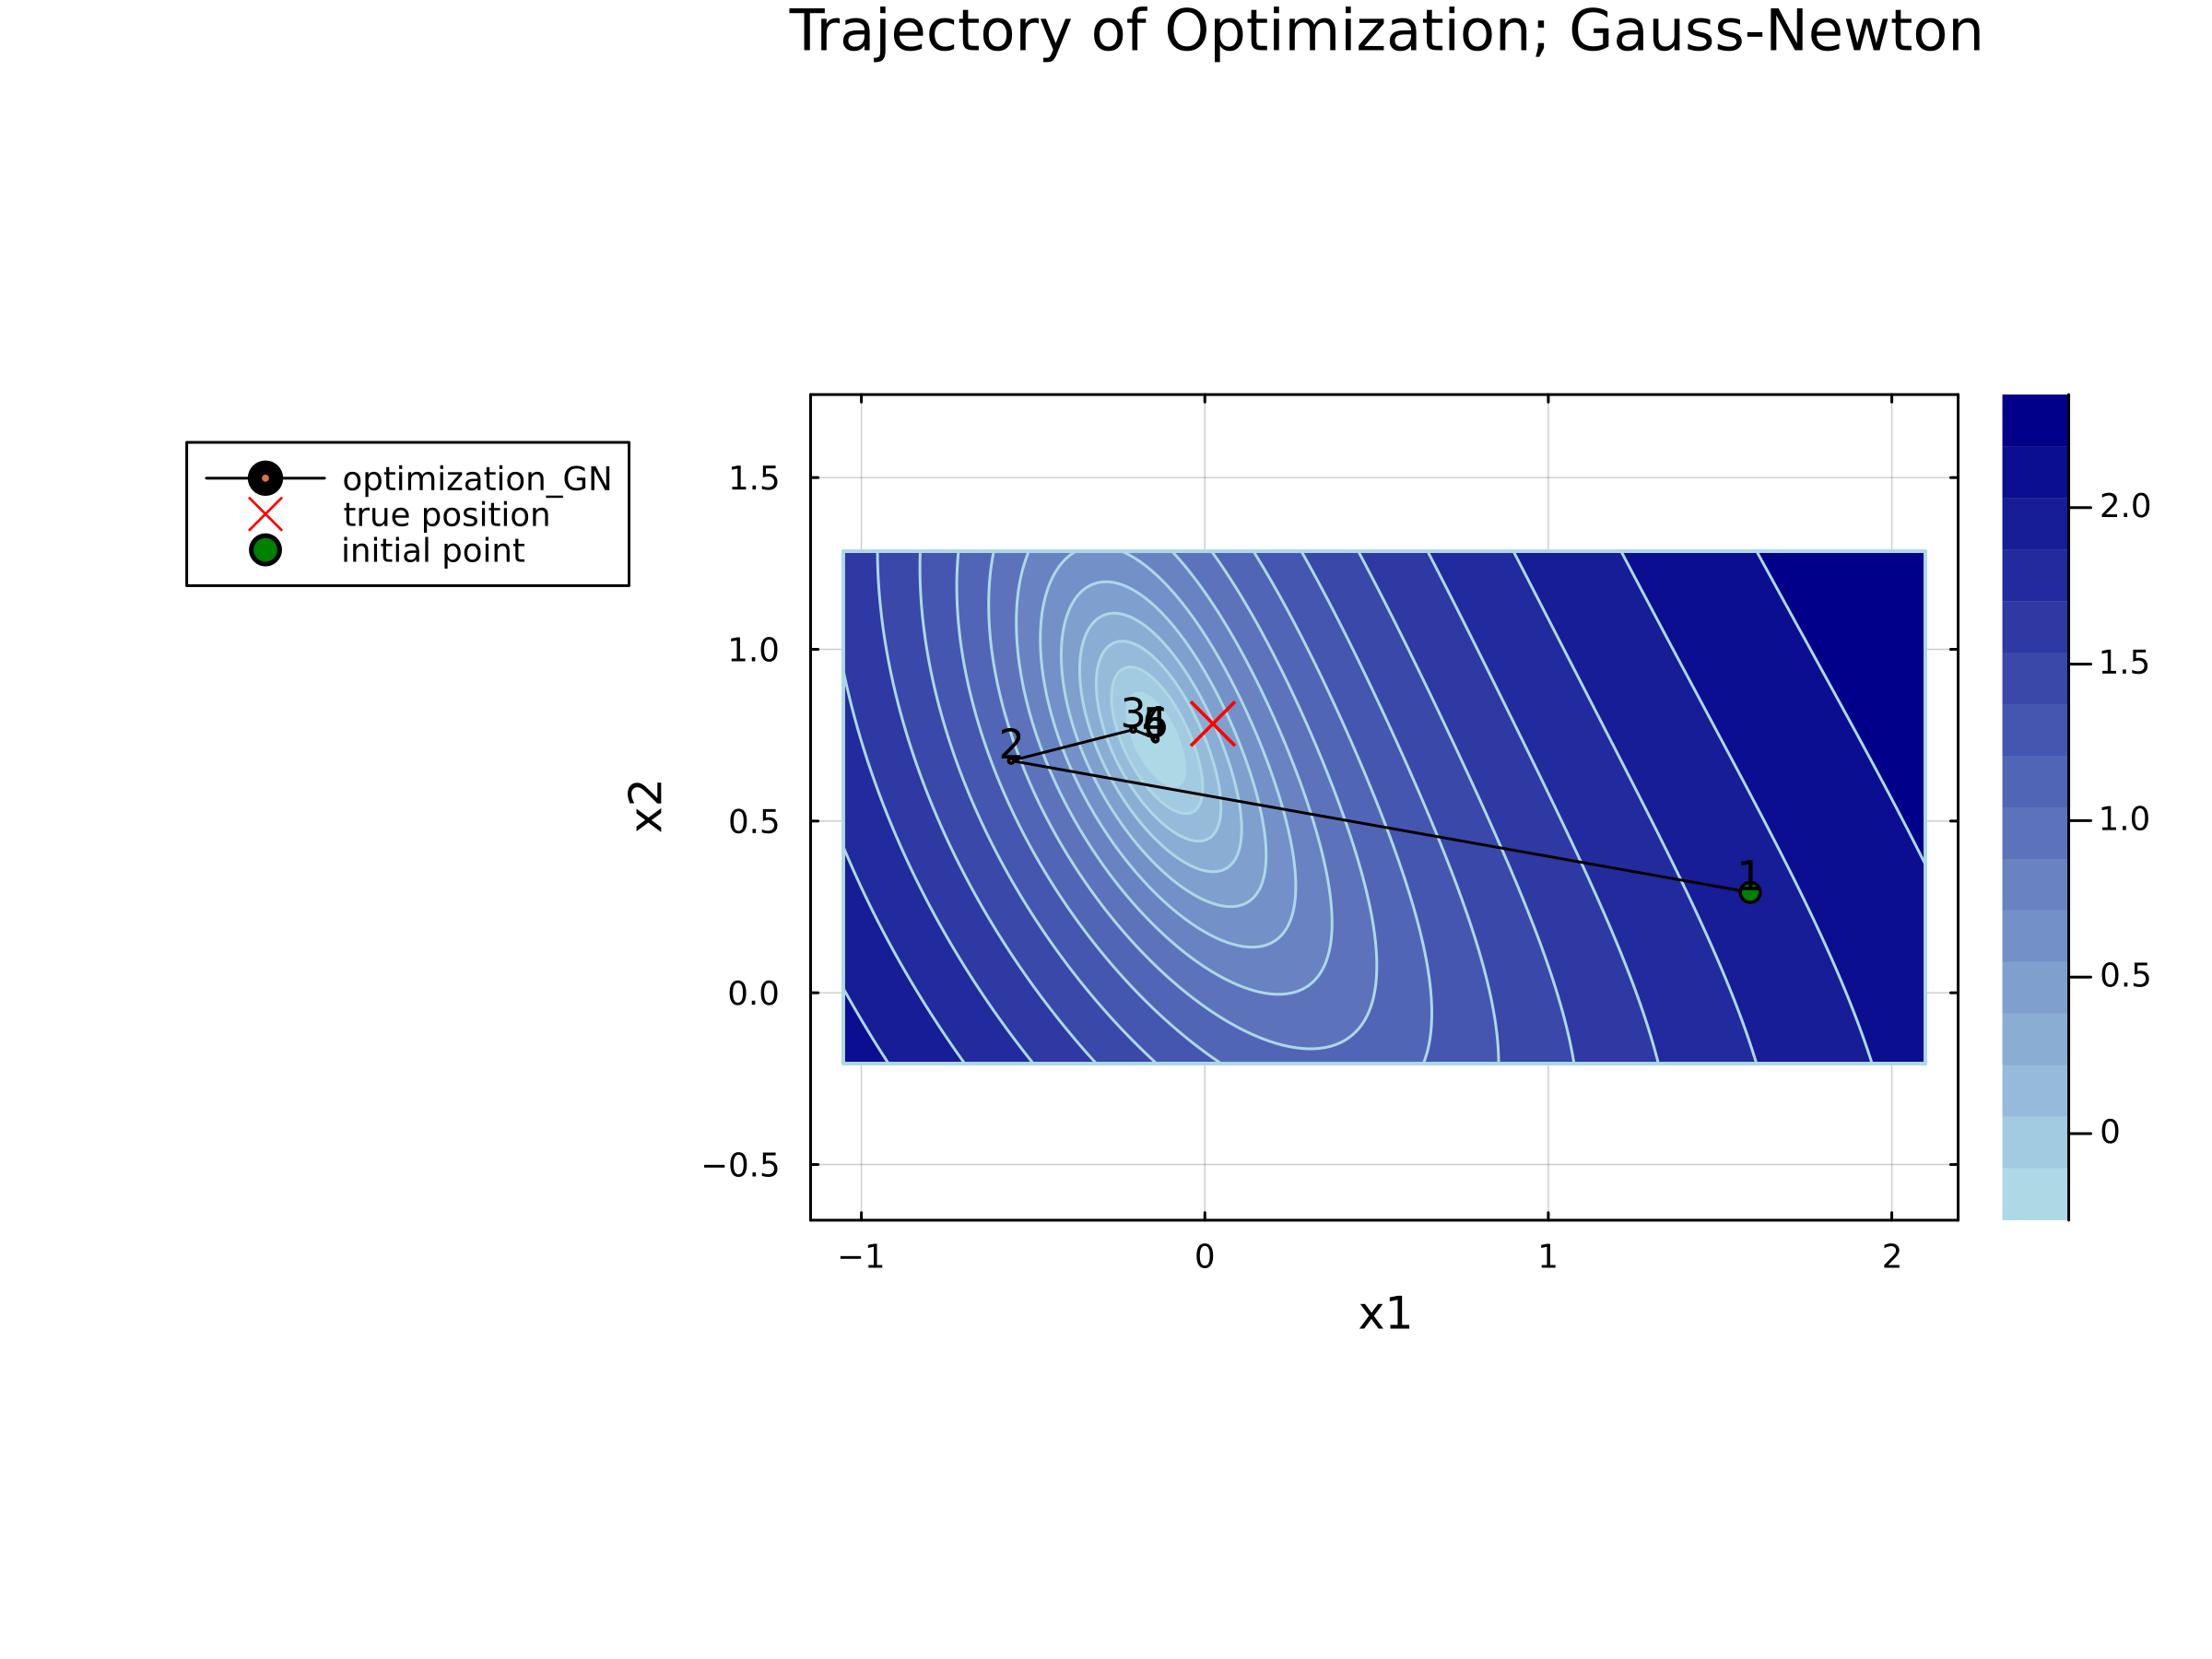

In [104]:
contourf(x1grid, x2grid, log10.(rgrid), colorbar_ticks=(tv2,tl2), color=:blues)
plot!(xtr2[1,:], xtr2[2,:], linecolor=:black, marker=:circle, 
    markerstrokecolor=:black, markersize=1, label="optimization_GN")

indices = 1:size(xtr2, 2)  # Generate indices for each point
for i in 1:length(indices)
    annotate!(xtr2[1, i], xtr2[2, i] + 0.05, text(indices[i], :black, :center, 10))
end
scatter!(sl.x[1,:], sl.x[2,:], label="true position", color=:red,shape=:xcross, ms=8)
scatter!([x0[1]], [x0[2]], label="initial point", color=:green, shape=:circle, ms=4)
plot!(leg=:outertopleft, frame=:box, title="Trajectory of Optimization; Gauss-Newton", 
    xlabel="x1", ylabel="x2", aspect_ratio=:equal, size=(800, 600), dpi=300)
#savefig("Hw4_extra_GN_tr.png")